***Import necessary libraries***

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

***Import files***

In [ ]:
from google.colab import files
tmdb_credits = files.upload()

In [ ]:
from google.colab import files
tmdb_movies = files.upload()

In [ ]:
df1 = pd.read_csv("tmdb_5000_credits.csv")
df2 = pd.read_csv("tmdb_5000_movies.csv")

**Explore data**

In [ ]:
print (len(df1))
print (len(df2))

4803
4803


In [ ]:
df1.head(2)

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."


In [ ]:
df2.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500


*Combine the two dataframes based on the common identifier*

In [ ]:
tf = df1.merge(df2, how='inner', left_on='movie_id', right_on='id')

In [ ]:
tf.head(2)

,movie_id,title_x,cast,crew,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title_y,vote_average,vote_count
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500


In [ ]:
tf.columns

Index(['movie_id', 'title_x', 'cast', 'crew', 'budget', 'genres', 'homepage',
       'id', 'keywords', 'original_language', 'original_title', 'overview',
       'popularity', 'production_companies', 'production_countries',
       'release_date', 'revenue', 'runtime', 'spoken_languages', 'status',
       'tagline', 'title_y', 'vote_average', 'vote_count'],
      dtype='object')

**Feature Engineering**

In [ ]:
#drop all irrelevant columns, a rather intuitive process
tf1 = tf.drop(['production_companies','budget','production_countries','original_language','title_x','title_y','release_date','homepage','keywords'],axis=1)

In [ ]:
tf1.head(1)

,movie_id,cast,crew,genres,id,original_title,overview,popularity,revenue,runtime,spoken_languages,status,tagline,vote_average,vote_count
0,19995,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",19995,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,7.2,11800


In [ ]:
# These functions will be used to obtain the necessary info from the jsonified columns
def cast_func(item):
  li = (eval(item))
  for item in li:
    if (item['order']) == 0:
      return item['name']


def genre_func(item):
  li = (eval(item))
  pack = []
  for item in li:
    pack.append(item["name"])
  return pack


def lang_func(item):
  li = (eval(item))
  pack = []
  for item in li:
    pack.append(item["iso_639_1"])
  return pack


def crew_func(item):
  li = (eval(item))
  for item in li:
    if (item['job']) == 'Director':
      return item['name']


In [ ]:
# Implement functions
tf1["cast"] = tf1["cast"].apply(lambda x: cast_func(x))
tf1["crew"] = tf1["crew"].apply(lambda x: crew_func(x))
tf1["genres"] = tf1["genres"].apply(lambda x: genre_func(x))
tf1["spoken_languages"] = tf1["spoken_languages"].apply(lambda x: lang_func(x))

In [ ]:
#check the dataframe to seew what we have
tf1.head(1)

,movie_id,cast,crew,genres,id,original_title,overview,popularity,revenue,runtime,spoken_languages,status,tagline,vote_average,vote_count
0,19995,Sam Worthington,James Cameron,"[Action, Adventure, Fantasy, Science Fiction]",19995,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,2787965087,162.0,"[en, es]",Released,Enter the World of Pandora.,7.2,11800


Check how the votes are skewed

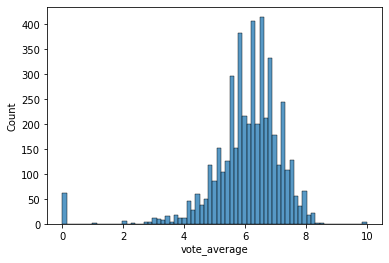

In [ ]:
sns.histplot(tf1.vote_average)

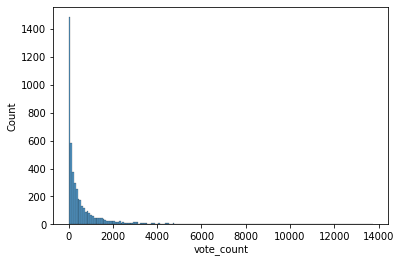

In [ ]:
sns.histplot(tf1.vote_count)

In [ ]:
tf1.describe()

,movie_id,id,popularity,revenue,runtime,vote_average,vote_count
count,4803.000000,4803.000000,4803.000000,4.803000e+03,4801.000000,4803.000000,4803.000000
mean,57165.484281,57165.484281,21.492301,8.226064e+07,106.875859,6.092172,690.217989
std,88694.614033,88694.614033,31.816650,1.628571e+08,22.611935,1.194612,1234.585891
min,5.000000,5.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,9014.500000,9014.500000,4.668070,0.000000e+00,94.000000,5.600000,54.000000
50%,14629.000000,14629.000000,12.921594,1.917000e+07,103.000000,6.200000,235.000000
75%,58610.500000,58610.500000,28.313505,9.291719e+07,118.000000,6.800000,737.000000
max,459488.000000,459488.000000,875.581305,2.787965e+09,338.000000,10.000000,13752.000000


**Implement content-based recommendation system based on cast, crew and genre**

In [ ]:
# Function removes spaces between the words for the relevant data, for word vectorisation
def snip(item):
    if isinstance(item, list):
        return [str.lower(x.replace(" ", "")) for x in item]
    else:
        if isinstance(item, str):
            return str.lower(item.replace(" ", ""))
        else:
            return ''

In [174]:
tf1["cast"] = tf1["cast"].apply(lambda x: snip(x))
tf1["crew"] = tf1["crew"].apply(lambda x: snip(x))
tf1["genres"] = tf1["genres"].apply(lambda x: snip(x))

In [175]:
tf1.head(2)

,movie_id,cast,crew,genres,id,original_title,overview,popularity,revenue,runtime,spoken_languages,status,tagline,vote_average,vote_count
0,19995,samworthington,jamescameron,"[action, adventure, fantasy, sciencefiction]",19995,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,2787965087,162.0,"[en, es]",Released,Enter the World of Pandora.,7.2,11800
1,285,johnnydepp,goreverbinski,"[adventure, fantasy, action]",285,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,961000000,169.0,[en],Released,"At the end of the world, the adventure begins.",6.9,4500


In [160]:
def combine(item):
        return (item['cast'] + ' ' + item['crew'] + ' ' + ' '.join(item['genres']))

In [176]:
#format and create a column for the word vector matrix
tf1['combined'] = tf1.apply(combine, axis=1)
tf1[['combined']].head(2).values

array([['samworthington jamescameron action adventure fantasy sciencefiction'],
       ['johnnydepp goreverbinski adventure fantasy action']],
      dtype=object)

In [177]:
# Create word vector matrix
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(tf1['combined'])
count_matrix.shape

(4803, 4381)

The cosine-similarity from sklearn  will measure the cosine angles between the vectors (from the word vector matrix) to determine similarity

In [178]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [179]:
tf2 = tf.reset_index()
indices = pd.Series(tf2.index, index=tf2['title_x'])
indices

title_x
Avatar                                         0
Pirates of the Caribbean: At World's End       1
Spectre                                        2
The Dark Knight Rises                          3
John Carter                                    4
                                            ... 
El Mariachi                                 4798
Newlyweds                                   4799
Signed, Sealed, Delivered                   4800
Shanghai Calling                            4801
My Date with Drew                           4802
Length: 4803, dtype: int64

In [202]:
# Function to get most similar movies
def chill(movie_title, cosine_sim=cosine_sim):
    movie_index = indices[movie_title]

    # Pairwise similarity scores
    similarity_scores = list(enumerate(cosine_sim[movie_index]))

    # Sorting the movies
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 5 most similar movies
    similarity_scores = similarity_scores[1:6]

    # Movie indices
    movie_indices = [i[0] for i in similarity_scores]

    # Return the top 5 most similar movies
    return tf['title_x'].iloc[movie_indices].values.tolist()

In [203]:
#Trying out the recommender system
chill('Avatar', cosine_sim)

['Clash of the Titans',
 'Superman Returns',
 'Man of Steel',
 'X-Men: Days of Future Past',
 'Jupiter Ascending']

*Obtain 30 movie titles for trial on the Flask Server*

In [185]:
c = tf.title_x.values.tolist()
c[:30]

['Avatar',
 "Pirates of the Caribbean: At World's End",
 'Spectre',
 'The Dark Knight Rises',
 'John Carter',
 'Spider-Man 3',
 'Tangled',
 'Avengers: Age of Ultron',
 'Harry Potter and the Half-Blood Prince',
 'Batman v Superman: Dawn of Justice',
 'Superman Returns',
 'Quantum of Solace',
 "Pirates of the Caribbean: Dead Man's Chest",
 'The Lone Ranger',
 'Man of Steel',
 'The Chronicles of Narnia: Prince Caspian',
 'The Avengers',
 'Pirates of the Caribbean: On Stranger Tides',
 'Men in Black 3',
 'The Hobbit: The Battle of the Five Armies',
 'The Amazing Spider-Man',
 'Robin Hood',
 'The Hobbit: The Desolation of Smaug',
 'The Golden Compass',
 'King Kong',
 'Titanic',
 'Captain America: Civil War',
 'Battleship',
 'Jurassic World',
 'Skyfall']

**FLASK APP**

In [186]:
import json
from flask import Flask, request, jsonify, render_template

In [187]:
# after running the flask app, run the link in output for the webpage
from google.colab.output import eval_js
print(eval_js("google.colab.kernel.proxyPort(5000)"))

https://azf7djmtvzs-496ff2e9c6d22116-5000-colab.googleusercontent.com/


In [208]:
app = Flask(__name__,template_folder="drive/My Drive/Colab Notebooks")

In [209]:
@app.route("/predict", methods=["POST"])
def predict():
  movie_title = request.form["movie_title"]
  return jsonify({"recommendations": chill(movie_title, cosine_sim)})

In [210]:
@app.route("/")
def index():
  return render_template("movies.html")

In [211]:
if __name__ == "__main__":
  print ("app running...")
  app.run()

app running...
 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [23/Oct/2020 01:01:58] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [23/Oct/2020 01:01:59] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [23/Oct/2020 01:02:02] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Oct/2020 01:02:11] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [23/Oct/2020 01:02:12] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [23/Oct/2020 01:02:28] "POST /predict HTTP/1.1" 200 -
